# Lab 1 : Visualization and Data Processing

## Group 4 :  Simerpreet Reddy, Rudranil Mitra, Samuel VonPaays Soh, Kristi Herman

---
## <font color='darkgreen'> Business Understanding </font>

The source selected for this analysis is a Craigslist used car listings dataset from Kaggle:  https://www.kaggle.com/austinreese/craigslist-carstrucks-data<br>  The author of this dataset used web scraping algorithms to scrape the information from all regional Craigslist's sites in the U.S posted between 10/28/2020 and 12/3/2020. 


#### <font color='green'>Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?)</font>
The purpose of this dataset is to collect data for all used cars and trucks for sale in the U.S. that are listed on Craigslist regional sites.  This dataset was selected to model and predict used car prices and to classify price ranges by categories.  Included in the dataset were other types of vehicles such as busses and motorcycles.  Those were removed to focus the analysis on cars and trucks only. 


#### <font color='green'>Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? </font>

We will know that we have mined useful knowledge if we are able to come up with a good prediction for used car prices and a classifier for price range predictions. In other words, a good model will be able to find relationships among the predictors and the response variables.  

#### <font color='green'>How would you measure the effectiveness of a good prediction algorithm? Be specific. </font>

Our goal is to run both both regression and classification algorithms on this dataset. For the regression problem to predict car prices, RMSE along with k-fold cross validation will be used to determine the effectiveness of the prediction. For the classification problem, k-fold cross validation with accuracy, precision, recall, True Positive Rate, and False Positive Rate will be used to measure the effectiveness of the prediction model. The value for 'k' in cross validation will be determined through hyperparameter tuning during the model building process.

## Data Meaning Type

*Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.*

<blockquote>The initial dataset contained <b>458,213 rows</b> with <b>26 fields</b>.

In [191]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import requests
import json
import time
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
cmap = sns.diverging_palette(220, 10, as_cmap=True)

In [231]:
#import vehicle dataset
orig_df = pd.read_csv('data/vehicles.csv') 

In [266]:
# Copy original file to car_df to avoid reloading the large file, keep the original dataset in case it is needed. 
car_df = orig_df.copy()

#info
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

<blockquote>These fields were immediately dropped for the following reasons:<br>
1) Not useful for the two prediction problems in this analysis (id, Unnamed:0, url, image_url, region_url, description)<br>
2) Too many missing values that could not be easily derived (size) <br> 
3) Similar to other fields (region) <br>
4) Dropping latitude and longitude because we can create a map using State

In [267]:
car_df = car_df.drop(columns=['id','Unnamed: 0','url','image_url','region_url','description','size','region','lat','long'])

<blockquote>This is a more detailed description of the fields that will be used for explanatory and response variables after some transformations are applied in Data Quality. </blockquote> 
   

In [237]:
%%html
<style>
table {float:left}
</style>

|<p>Field Name|<p>Description|Type|Scale|
|:-----|:-----|:-----|:-----|
|<p>price |<p>The price of the vehicle. |integer |ratio |
|<p>price_range$ |<p>Price category derived from "price" field, e.g., 5,000 - 10,000. |category |ordinal |
|<p>manufacturer |<p>Manufacturer of the vehicle, e.g., honda, jeep, etc.  There are 44 unique values. |category |nominal |
|<p>model |<p>Model of the vehicle, e.g., f150, malibue, etc.  There are 31,521 unique models. |category |nominal |
|<p>condition_new |<p>Condition of the car with 4 values (salvage, fair_good, excellent_likenew, new).  This field combined some of the values in the original "condition" field. |category |ordinal |
|<p>cyclinders |<p>Number of cylinders in the car ranging from 1 to 12. |integer |interval |
|<p>fuel |<p>Type of fuel with the following categories:  'gas', 'diesel', 'other', 'hybrid', 'electric'. |category |nominal |
|<p>odometer |<p>Mileage recorded for the vehicle |integer |ratio |
|<p>title_status |<p>Indicates what the title status is of the vehicle:  'clean', 'lien', 'missing', 'salvage', 'rebuilt', 'parts only'. |category |nominal |
|<p>transmission_new |<p>Type of transmission:   'other', 'automatic', 'manual'.  This field combined some of the categories from the original 'transmission' field. |category |nominal |
|<p>drive |<p>Type of drive: ' rwd', 'fwd', '4wd'. |category |nominal |
|<p>type_new |<p>Type of vehicle with 9 categories after combining some from the original types:  'sedan', 'pickup_truck', 'coupe', 'crossover', 'mini-van','convertible', 'hatchback', 'van', 'offroad'. |category |nominal |
|<p>paint_color_new |<p>Color of the vehicle with 4 categories after combining some from the original colors:  'BlSlvrWhGryMsng', 'BluRdBrwn', 'OrYlwGrnPrpl', 'Custom'. |category |nominal 
|<p>state |<p>State of listing including all 50 states and DC. |category |nominal |
|<p>car_Age_in_yrs |<p>Derived from the original year column and the date of the posting. |integer |ratio |

All the categorical variables will be One Hot Encoded in the [New Features](#New-Features) section below.

## Data Quality
Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods

### Duplicate Data (Rudranil)

<blockquote>There were multiple duplicate for VINs becaues the same car could be listing in multiple regions in Craiglist.  The duplicates were removed.  

In [ ]:
#rudranil to add code/notes

### Missing values

<blockquote>There were a significant number of missing values in the original dataset. Expand this section to show that how we are handling missing values 

In [218]:
#n/a's
car_df.isna().sum()

price                0
year               145
manufacturer     18220
model             3837
condition       192940
cylinders        80402
fuel               415
odometer         55303
title_status      2577
transmission      1940
VIN             187549
drive            92235
type            112738
paint_color     140843
state                0
lat               7448
long              7448
posting_date        28
dtype: int64

<blockquote>Some data such as cylinders, year, fuel, drive, transmission, and model could be attained from the Department of Transportation using the VIN number.  A scraper was built to retrieve the data.  More details about the scraper are in the <a href='#exceptional'>Exceptional section</a> .Once the data was retrieved, it was exported to a separate csv and imported and merged into car_df to fill in missing values by VIN.

In [219]:
#import VIN dataset
vin_df  = pd.read_csv('data/vin_data.csv',sep='|', encoding='latin-1')

In [268]:
# Merge the VIN dataset with the original dataset
# With this merge we are able to fill out many missing values in the original dataset 

# Creating a SK Learn Transformer template, will be useful later to generate a 
# data cleaning pipeline 
class MergeTransform(BaseEstimator, TransformerMixin):
    def __init__(self,original_dataset,column_map,columns_to_drop,join_column):
        self.original_dataset = original_dataset
        self.column_map = column_map
        self.columns_to_drop = columns_to_drop
        self.join_column = join_column
    #
    def fit(self, X, y = None):
        return self
    #
    def transform(self, X, y = None):
        #
        X = X.drop_duplicates(['VIN'])
        #
        merged_dataset = pd.merge(self.original_dataset, X, how='left',on=self.join_column)
        #
        for k,v in self.column_map:
            merged_dataset[k].fillna(merged_dataset[v],inplace=True)
        #
        merged_dataset.drop(self.columns_to_drop,axis = 1, inplace = True)
        merged_dataset['cylinders']=merged_dataset['cylinders'].replace({'cylinders':''},regex=True)
        #
        return merged_dataset
    
# The datasets will be joined on VIN
join_col = ['VIN']

# These are the columns that are being cleaned up. The column on the left is the from the cars dataset. These columns
# have null values and need to be replaced from the VIN dataset
column_transform_map = [['cylinders', 'EngineCylinders'],
                        ['year', 'ModelYear'],
                        ['fuel', 'FuelTypePrimary'],
                        ['drive', 'DriveType'],
                        ['transmission', 'TransmissionStyle'],
                        ['model', 'Model']]

# These are additional columns from the VIN dataset an can be dropped after the merge 
columns_to_drop = ['DriveType', 'EngineCylinders', 'EngineManufacturer', 'EngineModel', 'Make', 'Manufacturer', 'Model', 'ModelYear', 'PlantCompanyName', 'TransmissionSpeeds', 'TransmissionStyle', 'FuelTypePrimary']

# Create an instance of the transformer
transformer = MergeTransform(car_df, column_transform_map, columns_to_drop, join_col)

# Run the transformer to generate the clean dataset
car_df = transformer.transform(vin_df)    

<blockquote>After merging the original dataset with the VIN dataset, the missing values have been reduced.

In [269]:
#n/as
car_df.isna().sum()

price                0
year               145
manufacturer     18220
model             3837
condition       192940
cylinders        80402
fuel               415
odometer         55303
title_status      2577
transmission      1940
VIN             187549
drive            92235
type            112738
paint_color     140843
state                0
posting_date        28
dtype: int64

<blockquote>The VIN column was then dropped since it was no longer needed for the analysis.

In [270]:
#drop extra ID fields, URL fields, region fields, and description
car_df = car_df.drop(columns=['VIN'])

<blockquote>For 7 of the columns that still have missing data and no source to obtain it, the rows with missing values were dropped (condition, title_status, drive, fuel, model, manufacturer, and year).  The remaining n/a's are combined with other fields in the section below for Re-Categorizing Data.

In [271]:
#drop rows with n/a for important variables that couldn't be obtained from the dept. of transportation
car_df = car_df[car_df['condition'].notna()]
car_df = car_df[car_df['title_status'].notna()]
car_df = car_df[car_df['drive'].notna()]
car_df = car_df[car_df['fuel'].notna()]
car_df = car_df[car_df['model'].notna()]
car_df = car_df[car_df['manufacturer'].notna()]
car_df = car_df[car_df['type'].notna()]
car_df['year'].dropna(inplace=True)

### Outliers

Price, year, and odometer had some major outliers. A lot of the extreme outliers seemed to be mistakes (e.g., 3.5 billion for price, 1900 for year). We implemented quantile method to screen out the outliers. We set the upper limit for the quantile to be 0.99 and lower limit to be 0.01. 

Year. The number of count for year reduced from 457,163 to 441,660 while the IQR ( delta between Q1- 25th percentiles and Q3-75th percentiles) stay the same. The mean of the two is about the same between 2010 and 2011. The left tail of the year distribution pull back significantly from 1900 to 1970 due to this outlier screening.

Odometer. The number of count reduced from 402,910 to 394,622. IQR is quite close between the two (93,123 vs 91,218). The std deviation is greatly improved from 3,228,623 to 58,661. The max of odometer reading changed from 2,043,756,000 (make no sense) to 269,930.

Price. The price has several extreme outliers which can go as high as $3.6 billion. The count reduced from 458,213 to 419,847. The IQR is extremely wide before outlier screening( 210,050 vs 16,002). The std devication is improved with outlier screening from 8,194,599 to 11,991. 

In [272]:
#remove extreme outliers for price and entries that seem to be dummy prices
# car_df=car_df[car_df['price'] < 4000000] 
# car_df = car_df.drop(car_df[(car_df.price == 1111111) | (car_df.price == 123456) | (car_df.price == 9999999)].index)

# Using quantile to remove outlier in column "price"
q_hi=car_df['price'].quantile(0.99)
q_low=car_df['price'].quantile(0.01)
car_df1 =car_df[(car_df['price']<q_hi)&(car_df['price']>q_low)]

q_hi=car_df1['year'].quantile(0.99)
q_low=car_df1['year'].quantile(0.01)
car_df1 =car_df1[(car_df1['year']<q_hi)&(car_df1['year']>q_low)]

q_hi=car_df1['odometer'].quantile(0.99)
q_low=car_df1['odometer'].quantile(0.01)
car_df1 =car_df1[(car_df1['odometer']<q_hi)&(car_df1['odometer']>q_low)]



In [273]:
car_df[['price','year','odometer']].describe()

,price,year,odometer
count,2.030010e+05,203001.000000,1.917620e+05
mean,3.524055e+04,2010.890168,1.061668e+05
std,8.038314e+06,8.010294,4.677272e+06
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.500000e+03,2008.000000,3.766400e+04
50%,1.195000e+04,2013.000000,8.574700e+04
75%,2.199500e+04,2016.000000,1.347300e+05
max,3.615215e+09,2021.000000,2.043756e+09


In [275]:
car_df1[['price','year','odometer']].describe()

,price,year,odometer
count,173449.000000,173449.000000,173449.000000
mean,15294.256813,2011.298024,94339.717652
std,11041.568001,5.945514,59592.115171
min,1.000000,1977.000000,181.000000
25%,6426.000000,2008.000000,42347.000000
50%,12590.000000,2013.000000,90000.000000
75%,22500.000000,2016.000000,136675.000000
max,52948.000000,2019.000000,269781.000000


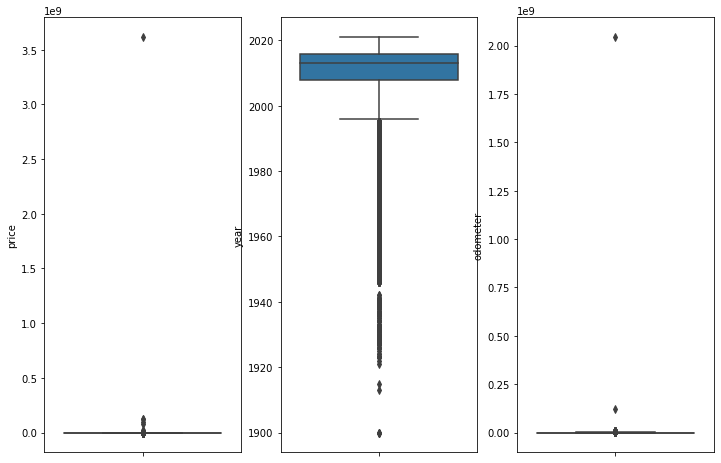

In [276]:
# boxplots after removing the outliers
fig, axs = plt.subplots(ncols=3, figsize=(12,8))
sns.boxplot(y=car_df['price'], ax=axs[0])
sns.boxplot(y=car_df['year'], ax=axs[1])
sns.boxplot(y=car_df['odometer'], ax=axs[2])
plt.show()

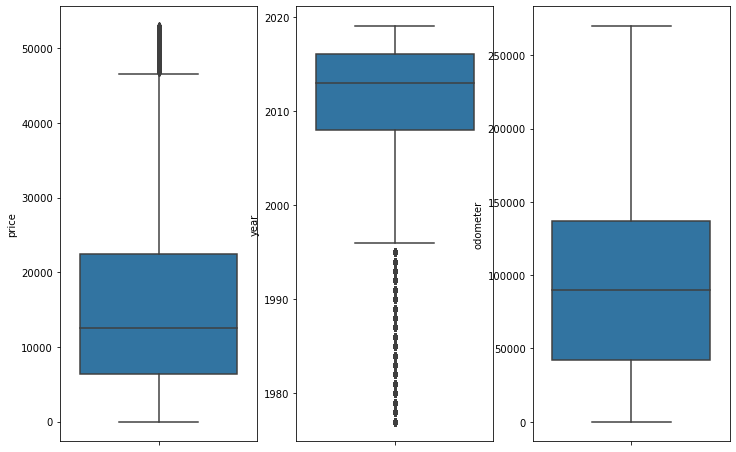

In [277]:
# boxplots after removing the outliers
fig, axs = plt.subplots(ncols=3, figsize=(12,8))
sns.boxplot(y=car_df1['price'], ax=axs[0])
sns.boxplot(y=car_df1['year'], ax=axs[1])
sns.boxplot(y=car_df1['odometer'], ax=axs[2])
plt.show()

### Re-Categorizing Data

### Add some verbiage regarding logic below 

In [308]:
# Regroup different drive types
drive_types = [
    (car_df['drive'] == "4WD/4-Wheel Drive/4x4")| (car_df['drive'] == "4wd") | (car_df['drive'] == "4WD/4-Wheel Drive/4x4") |  (car_df['drive'] == "2WD/4WD") | (car_df['drive'] == "6x4") | (car_df['drive'] == "6x2") | (car_df['drive'] == "AWD/All Wheel Drive"),
    (car_df['drive'] == "4x2") | (car_df['drive'] == "2WD/4WD")| (car_df['drive'] == "FWD/Front Wheel Drive")| (car_df['drive'] == "fwd") ,
    (car_df['drive'] == "RWD/ Rear Wheel Drive") | (car_df['drive'] == "rwd"),
    (car_df['drive'] == "Not Applicable") | (car_df['drive'] == "Other") | (car_df['drive'] == "Glider")
     ]
#new drive categories
drive_values = [ '4wd','fwd', 'rwd', 'others']
#new drive column
car_df['drive_new'] = np.select(drive_types, drive_values)
car_df['drive_new'].unique()

array(['0', 'fwd', 'rwd', '4wd', 'others'], dtype=object)

<blockquote>One of the goals of this project is to predict categorical responses for price range.  A new category field named "price_range" was derived from the "price" field. There are seven categories 

<br>
less than 1K <br>
1K-5K <br>
5K-10K <br>
10K-15K <br>
15k-30K <br>
30K-50K <br>
greater than 50K <br>
    

In [280]:
#Create column price_range to classify price of a car into one of the following groups: ('<1K' < '1K-5K' < '5K-10K' < '10K-15K' < '15k-30K' < '30K-50K' < '>50K'etc.)

car_df = car_df1.copy()
car_df['price_range'] = pd.cut(x=car_df['price'], bins=[-1, 1000, 5000,10000,15000,30000,50000, 100000],labels=['<1K', '1K-5K', '5K-10K','10K-15K', '15k-30K','30K-50K', '>50K' ])
car_df['price_range'].unique()

['30K-50K', '5K-10K', '15k-30K', '1K-5K', '10K-15K', '<1K', '>50K']
Categories (7, object): ['<1K' < '1K-5K' < '5K-10K' < '10K-15K' < '15k-30K' < '30K-50K' < '>50K']

<blockquote>"Conditions" that were similar to each other were grouped together in a condition_new field.

In [281]:
#combine conditions to 4 categories with the following groupings ('good', 'fair'), ('excellent','like new'), 'salvage', 'new' 
conditions = [
    (car_df['condition'] == "good") | (car_df['condition'] == "fair"),
    (car_df['condition'] == "excellent") | (car_df['condition'] == "like new"),
    (car_df['condition'] == "salvage"),
    (car_df['condition'] == "new")
    ]

#new condition categories
values = ['good_fair', 'excellent_likenew', 'salvage', 'new']

#new condition column
car_df['condition_new'] = np.select(conditions, values)
car_df['condition_new'].unique()

array(['good_fair', 'excellent_likenew', 'new', 'salvage'], dtype=object)

In [283]:
#drop the original condition field
car_df = car_df.drop(columns=['condition'])

KeyError: "['price_range$'] not found in axis"

<blockquote>'Transmission' types that were similar were grouped together in a new 'transmission_new' field with these final categories: Automatic, Manual, and Other. The other field consists of transmissions such as Semi-Automatic and Dual-Clutch.

In [284]:
#Group different transmission categories. 
car_df['transmission'] = car_df['transmission'].fillna('other')
transmission_types = [
    (car_df['transmission'] == "automatic") | (car_df['transmission'] == "Automatic") | (car_df['transmission'] == "Continuously Variable Transmission (CVT)"),
    (car_df['transmission'] == "manual") | (car_df['transmission'] == "Manual/Standard"),
    (car_df['transmission'] == "other")
    ]

#new transmission categories
t_values_types = ['Automatic', 'Manual', 'Other']

#new transmission column
car_df['transmission_new'] = np.select(transmission_types, t_values_types)
car_df['transmission_new'].unique()

array(['Other', 'Automatic', 'Manual'], dtype=object)

In [285]:
#drop the original transmission field
car_df = car_df.drop(columns=['transmission'])

<blockquote>Car 'types' that were similar were grouped together in a new 'type_new' field with these final categories: 'sedan', 'pickup_truck', 'coupe', 'crossover', 'mini-van', 'convertible', 'hatchback', 'van', 'offroad'.

In [286]:
#Combine types to: 'sedan', ('wagon','SUV') and call it 'crossover', ('pickup', 'truck'), 'coupe', 'van', 'mini-van', 'convertible', 'hatchback', 'offroad'
car_df['type'] = car_df['type'].fillna('')
car_df = car_df[car_df['type'].isin(['sedan', 'SUV', 'pickup', 'coupe', 'van', 'truck','mini-van', 'wagon', 'convertible', 'hatchback','offroad',''])]

types = [
    (car_df['type'] == "wagon") | (car_df['type'] == "SUV"),
    (car_df['type'] == "pickup") | (car_df['type'] == "truck"),
    (car_df['type'] == "sedan"),
    (car_df['type'] == "coupe"),
     (car_df['type'] == "van"),
    (car_df['type'] == "mini-van"),
     (car_df['type'] == "wagon"),
    (car_df['type'] == "convertible"),
     (car_df['type'] == "hatchback"),
    (car_df['type'] == "offroad"),
    (car_df['type'] == "")
    ]
#new condition categories
values_types = ['crossover', 'pickup_truck', 'sedan', 'coupe','van','mini-van','wagon','convertible','hatchback','offroad','']
#new condition column
car_df['type_new'] = np.select(types, values_types)
car_df.head()
car_df['type_new'].unique()

array(['sedan', 'pickup_truck', 'coupe', 'crossover', 'mini-van',
       'convertible', 'hatchback', 'van', 'offroad'], dtype=object)

In [287]:
#drop the original type field
car_df = car_df.drop(columns=['type'])

<blockquote>Paint colors that were similar were grouped together in a new 'paint_color_new' field with these final categories: 'BlSlvrWhGryMsng', 'BluRdBrwn', 'OrYlwGrnPrpl', 'Custom'.

In [288]:
car_df['paint_color'] = car_df['paint_color'].fillna('')
paint_color_grps = [
    (car_df['paint_color'] == "black") | (car_df['paint_color'] == "silver") | (car_df['paint_color'] == "white")|(car_df['paint_color'] == "grey")|(car_df['paint_color'] == '')  ,
    (car_df['paint_color'] == "blue") | (car_df['paint_color'] == "red")| (car_df['paint_color'] == "brown"),
    (car_df['paint_color'] == "orange")| (car_df['paint_color'] == "yellow")| (car_df['paint_color'] == "green")| (car_df['paint_color'] == "purple"),
    (car_df['paint_color'] == "custom")
    ]
#new paint groups
values_paint = ['BlSlvrWhGryMsng', 'BluRdBrwn', 'OrYlwGrnPrpl', 'Custom']
#new condition column
car_df['paint_color_new'] = np.select(paint_color_grps, values_paint)
car_df['paint_color_new'].unique()

array(['BlSlvrWhGryMsng', 'BluRdBrwn', 'OrYlwGrnPrpl', 'Custom'],
      dtype=object)

In [289]:
#drop the original color field
car_df = car_df.drop(columns=['paint_color'])

In [292]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162685 entries, 0 to 163045
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   price             162685 non-null  int64   
 1   year              162685 non-null  float64 
 2   manufacturer      162685 non-null  object  
 3   model             162685 non-null  object  
 4   cylinders         156066 non-null  object  
 5   fuel              162685 non-null  object  
 6   odometer          162685 non-null  float64 
 7   title_status      162685 non-null  object  
 8   drive             162685 non-null  object  
 9   state             162685 non-null  object  
 10  posting_date      162685 non-null  object  
 11  price_range       162685 non-null  category
 12  condition_new     162685 non-null  object  
 13  transmission_new  162685 non-null  object  
 14  type_new          162685 non-null  object  
 15  paint_color_new   162685 non-null  object  
 16  pe

### Other cleanup

<blockquote>After the merge with the Dept. of Transportation data, the cylinders were repeated in different formats.  This column was converted to an int. 

In [293]:
## fill null with Z and remove later
car_df['cylinders'] = car_df['cylinders'].fillna('Z')

In [294]:
# transform cylinders to integer format
car_df.drop(car_df[car_df['cylinders']=='Z'].index,inplace=True)
car_df.drop(car_df[car_df['cylinders']=='other'].index,inplace=True)
car_df['cylinders'] = car_df['cylinders'].astype('int64')

In [295]:
car_df['cylinders'].unique()

array([ 4,  8,  6,  5,  2,  3, 10, 12,  1], dtype=int64)

<blockquote>The Harley-Davidsons were removed since they are motorcycles and this study is focused on cars.

In [296]:
# drop "harley-davidson"
car_df = car_df.drop(car_df[(car_df.manufacturer == "harley-davidson")].index)

<blockquote>The "posting_date" was converted to a datetime object.  This will be used to derive a new column for the age of the car in the New Features section.

In [306]:
#convert posting_date to datetime object
car_df['posting_date'] = car_df['posting_date'].fillna('')
car_df['posting_date'] = car_df['posting_date'].astype(str)
new_post_Dt= car_df['posting_date'].str.split('T', n = 1, expand = True)
car_df["posting_date"]= new_post_Dt[0]
car_df["posting_date"]=car_df["posting_date"].astype('datetime64[ns]')

0          6.0
2          6.0
4          6.0
5          6.0
6          6.0
          ... 
163041    35.0
163042    35.0
163043    35.0
163044    35.0
163045    35.0
Length: 155766, dtype: float64

In [320]:
car_df['car_Age_in_yrs'] = car_df['posting_date'].dt.year - car_df['year']
car_df = car_df.drop(columns=['year'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155766 entries, 0 to 163045
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   price             155766 non-null  int64         
 1   manufacturer      155766 non-null  object        
 2   model             155766 non-null  object        
 3   cylinders         155766 non-null  int64         
 4   fuel              155766 non-null  object        
 5   odometer          155766 non-null  float64       
 6   title_status      155766 non-null  object        
 7   drive             155766 non-null  object        
 8   state             155766 non-null  object        
 9   posting_date      155766 non-null  datetime64[ns]
 10  price_range       155766 non-null  category      
 11  condition_new     155766 non-null  object        
 12  transmission_new  155766 non-null  object        
 13  type_new          155766 non-null  object        
 14  pain

### Simple Statistics (Rudranil)
Visualize appropriate statistics (e.g., range, mode, mean, median, variance, counts) for a subset of attributes. Describe anything meaningful you found from this or if you found something potentially interesting. Note: You can also use data from other sources for comparison. Explain why the statistics run are meaningful. 

In [36]:
car_df.describe()

,price,year,cylinders,odometer,lat,long,percent
count,178505.000000,178505.00000,178505.000000,178505.000000,176966.000000,176973.000000,178505.000000
mean,14540.671107,2010.77962,5.804868,99492.217428,38.485166,-92.079877,5.209461
std,10920.180690,6.70603,1.608285,65597.100468,5.414029,16.804180,2.066219
min,1.000000,1964.00000,1.000000,0.000000,18.278511,-159.713745,0.050092
25%,5990.000000,2007.00000,4.000000,46608.000000,34.868800,-99.077900,4.072290
50%,11500.000000,2012.00000,6.000000,95784.000000,39.319607,-86.236775,5.157441
75%,20990.000000,2016.00000,8.000000,141300.000000,42.300673,-80.183000,7.024218
max,52985.000000,2020.00000,12.000000,999999.000000,64.993698,-67.382100,7.725003


### Visualize Attributes (Simerpreet)
Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.

<AxesSubplot:title={'center':'Condition & Price'}, xlabel='condition_new', ylabel='price'>

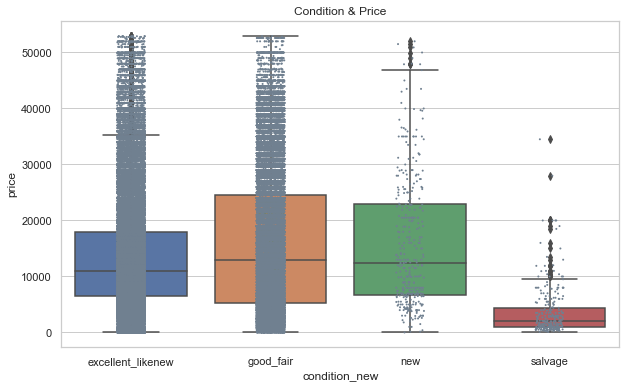

In [388]:
car_df['condition_new'].value_counts()
#boxplot for condition of car
fig, axs = plt.subplots(ncols=1, figsize=(10,6))
ax = sns.boxplot(x="condition_new", y="price", data=car_df).set(title='Condition & Price', xlabel='Condition', ylabel='Price (USD)')
# Add in points to show each observation
sns.stripplot(x="condition_new", y="price", data=car_df,
              jitter=True, size=2, color="slategrey", linewidth=0)

Text(0, 0.5, 'Number of Cars')

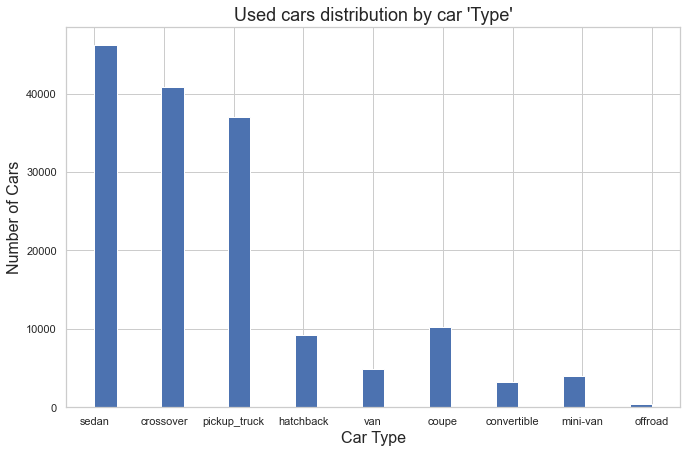

In [389]:
#Plot Used cars distribution in by car type
plt.subplots(figsize = (11,7))
car_df['type_new'].hist(bins=25)
plt.title("Used cars distribution by car 'Type'", fontsize=18)
plt.xlabel('Car Type', fontsize=16)
plt.ylabel('Number of Cars', fontsize=16)

Text(0.5, 0, 'Drive')

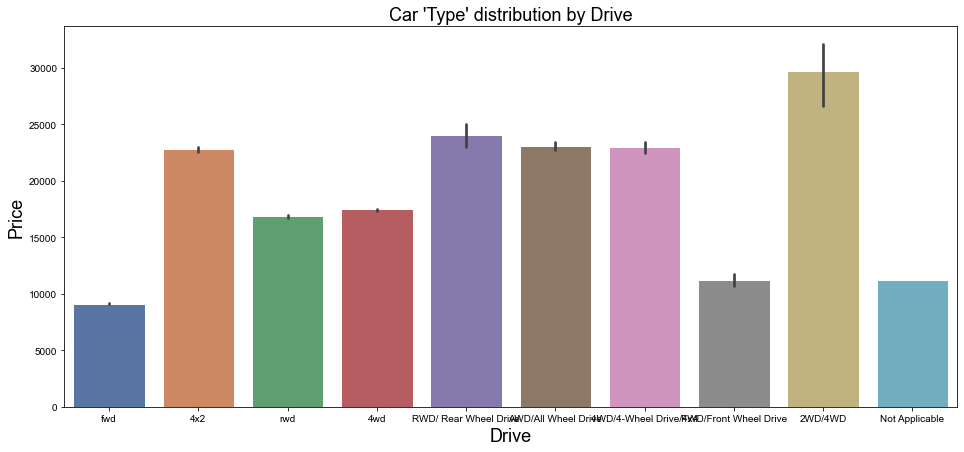

In [309]:
#Histogram for Numbers of cars in each price range by drive
fig, ax = plt.subplots(figsize = (16,7))
sns.set_theme(style="whitegrid")
plt.title("Car 'Type' distribution by Drive", fontsize=18)
ax = sns.barplot(y="price", x="drive", data=car_df)
ax.set_ylabel('Price', fontsize = 18)
ax.set_xlabel ('Drive', fontsize = 18)

### Explore Joint Attributes (Simerpreet)
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.

### Correlations we see from the plot below:
1) A strong negative correlation between Price and Odometer reading. <br>
2) A strong negative correlation between Price and the age of the car. <br>
3) A strong postive correlation between Odometer reading and the age of the car. <br>
4) A slight positive correlation between the number of cyclinders and the price of the car. <br>
5) A very week correlation between the number of cylinders and the age of the car <br>

                   price  cylinders  odometer  car_Age_in_yrs
price           1.000000   0.336604 -0.597301       -0.566293
cylinders       0.336604   1.000000  0.074707        0.156230
odometer       -0.597301   0.074707  1.000000        0.599262
car_Age_in_yrs -0.566293   0.156230  0.599262        1.000000


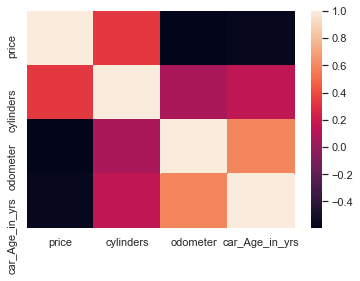

In [322]:
car_df = car_df.drop(columns=['percent'])
correlations = car_df.corr()
print(correlations)
sns.heatmap(correlations)
plt.show()

<blockquote> California followed by Florida have the most number of 'excellent_likenew' cars for sale on craiglist for the time period of this dataset.

Text(0.5, 1.0, 'Used cars distribution by State')

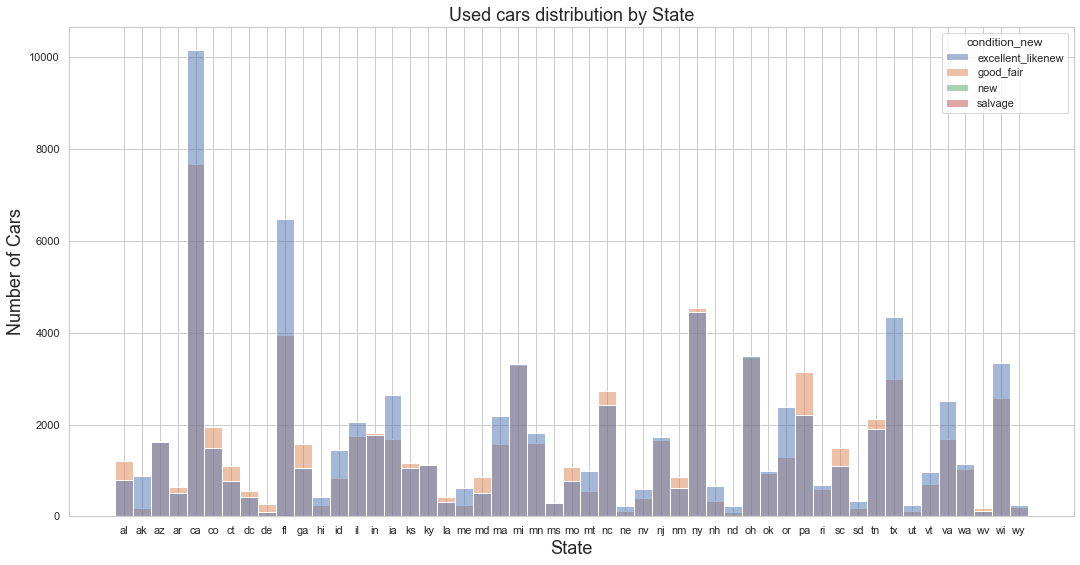

In [336]:
#Plot Used cars distribution by State
fig, ax1 = plt.subplots(figsize = (18,9))
ax1 = sns.histplot(x="state",hue="condition_new", data=car_df)
ax1.set_ylabel('Number of Cars', fontsize = 18)
ax1.set_xlabel ('State', fontsize = 18)
plt.title("Used cars distribution by State", fontsize=18)

### We can observe the following from the plot below:

1) For each car type, the cars with the highest odometer reading are in 'salvage' condition. <br>
2) Off-road vehicles, followed by pickup_trucks and vans have the highest odometer reading for the salvage cars.<br>
3) Convertible cars seem to be inconsistent, with around the same odometer reading, comparable number of cars are in 'excellent_likenew' condition or 'salvage' condition.<br>
4) For pick_up trucks, hatchbacks and coupes, the cars in 'excellent_likenew' condition have higher odometer reading compared to these types of cars in 'good/fair' condition. We saw from the plot above that the price for these car types was higher for cars in good/fair condition compared to those in 'excellent/like-new' condition.<br>
Thus car_condition, car_type along with the odometer reading can be good predictors of the price of the car.

Text(0.5, 0, ' Car Type by condition')

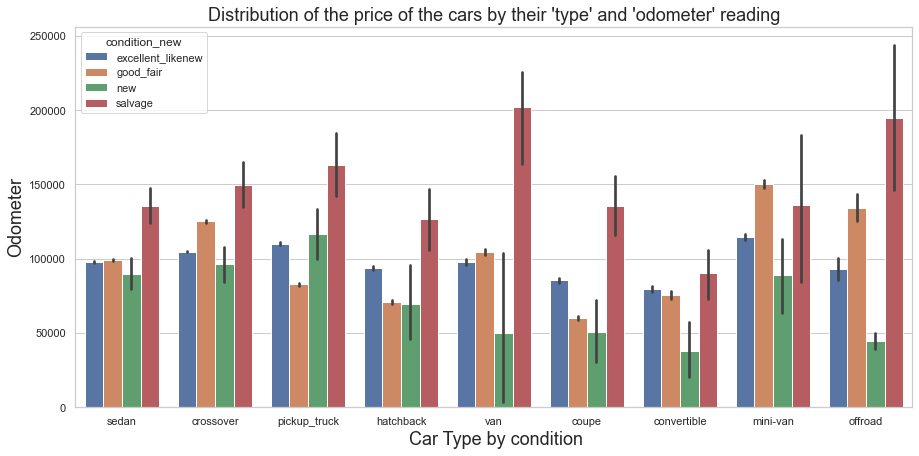

In [328]:
# Basic correlogram
# sns.pairplot(car_df,hue="transmission_new")

# Draw Seaborn Scatter Plot to find relationship between age and fare


#Distribution of cars by their odometer reading, type and condition
fig, ax = plt.subplots(figsize = (15,7))
sns.set_theme(style="whitegrid")
plt.title("Distribution of the price of the cars by their 'type' and 'odometer' reading", fontsize=18)
ax = sns.barplot(y="odometer",x="type_new", hue="condition_new", data=car_df)
ax.set_ylabel('Odometer', fontsize = 18)
ax.set_xlabel (' Car Type by condition', fontsize = 18)



### Explore Attributes and Class
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

#### Features and Price (Regression)


<blockquote>There are two continuous features in the dataset - car age in years and odometer.  Prices are trending down as vehicles age until the 40-year mark when prices start to rise again.  This is from the classic cars in the dataset.  For mileage, the trend for prices is down as mileage increases, as would be expected.  <br>
From visual inspection of the colors, there seem to be more higher-priced cars in the Excellent/Like New categories.


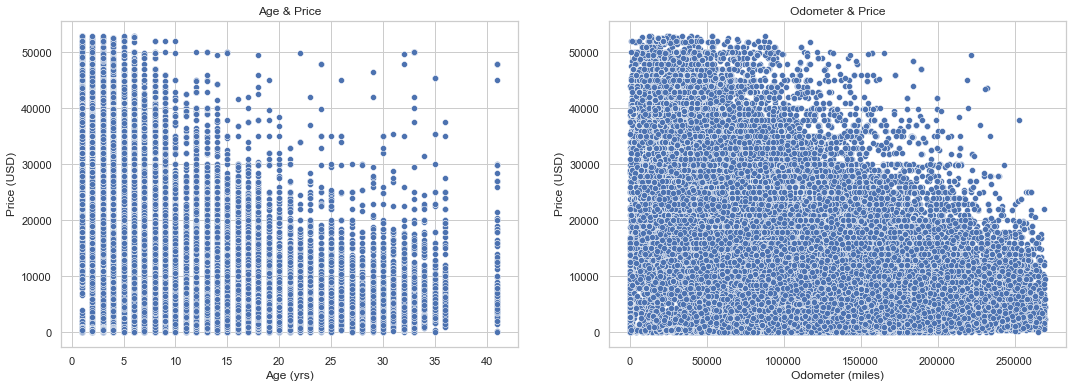

In [331]:
#scatterplots for continuous of car age and odometer by price
fig, axs = plt.subplots(ncols=2, figsize=(18,6))
sns.scatterplot(data=car_df, x="car_Age_in_yrs", y="price", ax=axs[0]).set(title='Age & Price', xlabel='Age (yrs)', ylabel='Price (USD)')
sns.scatterplot(data=car_df, x="odometer", y="price", ax=axs[1]).set(title='Odometer & Price', xlabel='Odometer (miles)', ylabel='Price (USD)')
plt.show()

<blockquote> There does not seem to be much correlation between state and price. West Virginia and Wyoming could be exception to this(There are not many observations in the dataset for West Virginia and Wyoming)

Text(0.5, 0, 'State')

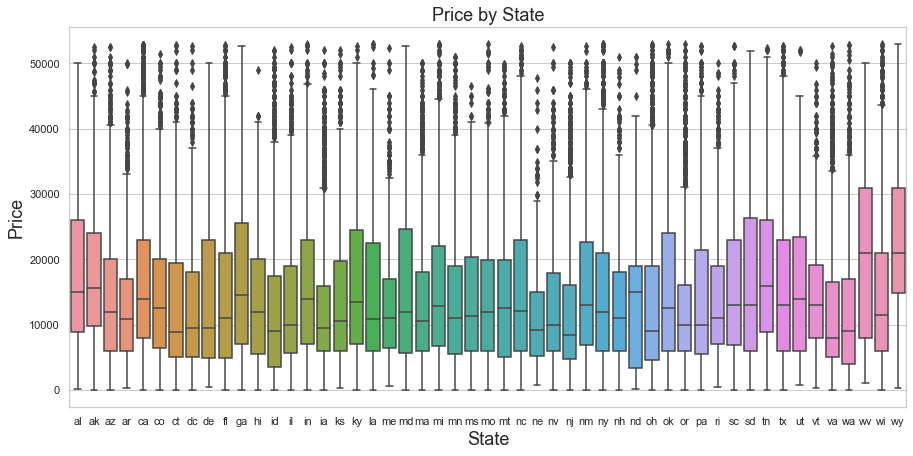

In [384]:
#Price by State
fig, ax = plt.subplots(figsize = (15,7))
sns.set_theme(style="whitegrid")
plt.title("Price by State", fontsize=18)
ax = sns.boxplot(y="price",x="state", data=car_df)
ax.set_ylabel('Price', fontsize = 18)
ax.set_xlabel ('State', fontsize = 18)

### Following observations can be made from the plot below:
1) New cars have the highest prices for cars in each car type. <br>
2) For pickup trucks, hatchbacks and convertible cars, the cars in good_fair condition appear to have higher prices than the cars in excellent_likenew cond.n for the same car types. Thus, apart from condition and type, there have to be other factors that influence the price of vehicles. <br>
3) Salvage cars have the least price for each car type. <br>

Text(0.5, 0, ' Car Type by condition')

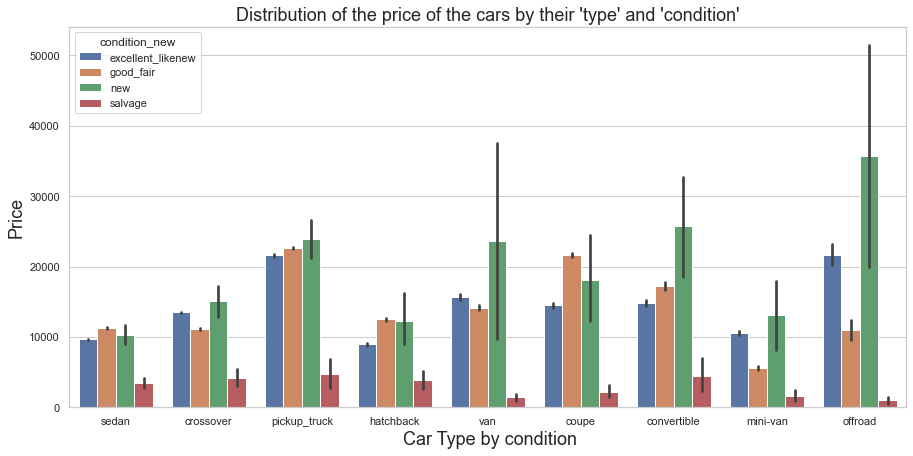

In [324]:
#Histogram for Numbers of cars in each price range by car condition
fig, ax = plt.subplots(figsize = (15,7))
sns.set_theme(style="whitegrid")
plt.title("Distribution of the price of the cars by their 'type' and 'condition'", fontsize=18)
ax = sns.barplot(y="price",x="type_new", hue="condition_new", data=car_df)
ax.set_ylabel('Price', fontsize = 18)
ax.set_xlabel (' Car Type by condition', fontsize = 18)

<blockquote>High-end manufacturers like Aston-Martin, Ferrari, Porshe, and Tesla have higher prices with medians over $30,000. The manufacturers with the lowest median prices are Mercury, Pontiac, and Saturn.  While the median is high for Tesla, there is a large range of values between the 25th PCTL and the 75th PCTL, indicating that there is a lot of variability in prices for this manufacturer.

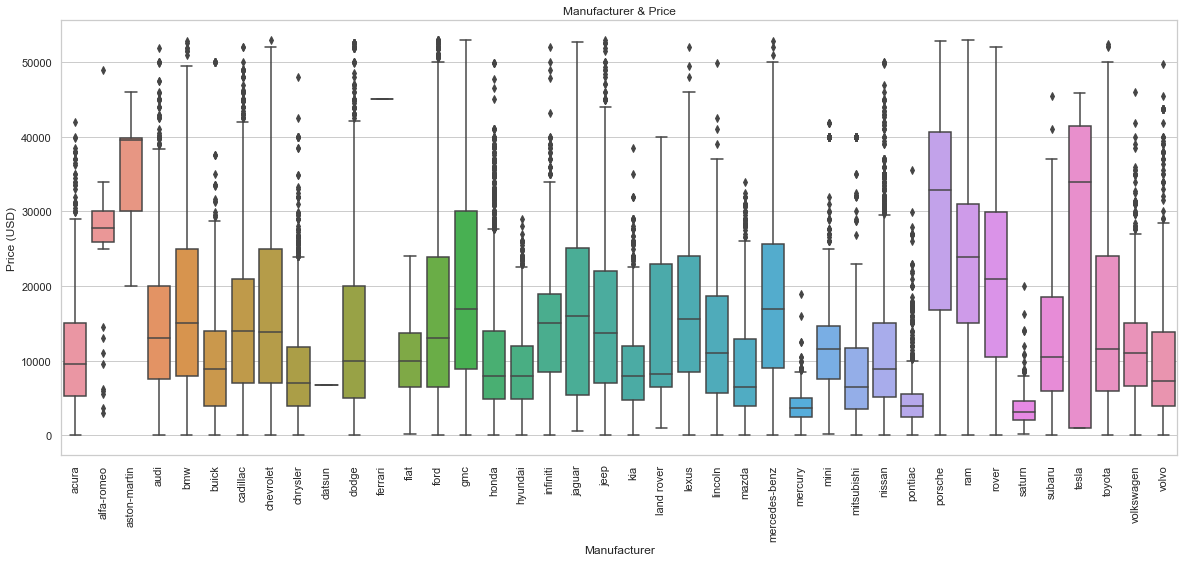

In [335]:
fig, axs = plt.subplots(ncols=1, figsize=(20,8))
ax = sns.boxplot(x="manufacturer", y="price", data=car_df.sort_values("manufacturer")).set(title='Manufacturer & Price', xlabel='Manufacturer', ylabel='Price (USD)')
plt.xticks(rotation=90)
plt.show()

<blockquote> Colors seem to have small correlation with price. Transmission seems to have correlation with price. 

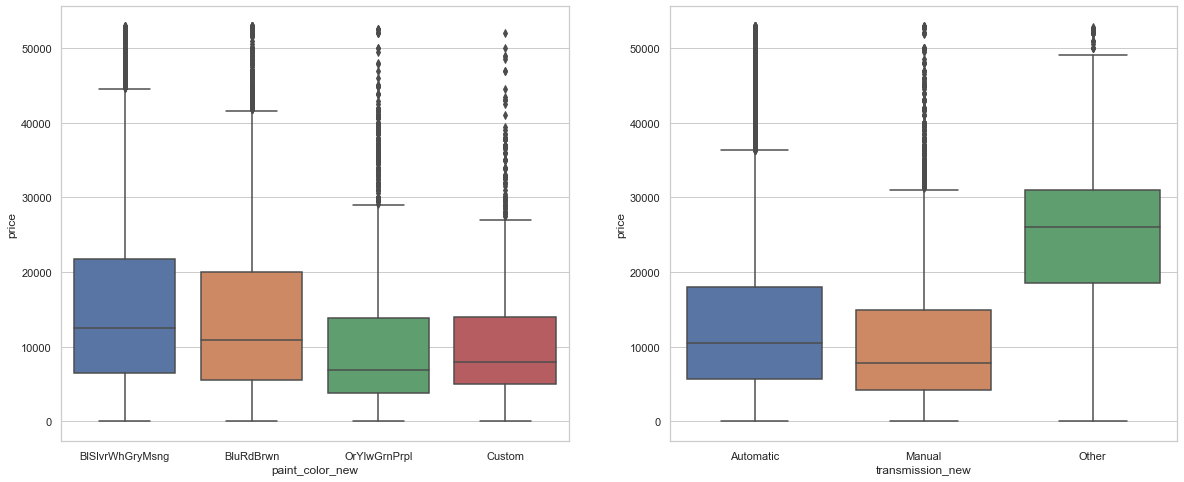

In [345]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))
ax = sns.boxplot(x="paint_color_new", y="price", data=car_df,ax=axs[0])
ax = sns.boxplot(x="transmission_new", y="price", data=car_df,ax=axs[1]) 

#### Categorical Features and Price Range (Classification)

Text(0, 0.5, 'Number of Cars')

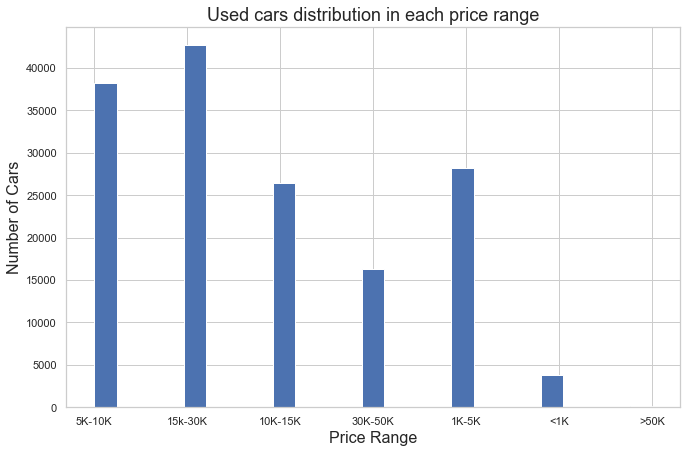

In [367]:
#Plot Used cars distribution in each price range
plt.subplots(figsize = (11,7))
car_df['price_range'].hist(bins=25)
plt.title('Used cars distribution in each price range', fontsize=18)
plt.xlabel('Price Range', fontsize=16)
plt.ylabel('Number of Cars', fontsize=16)

<blockquote> For classification problems, the prices have been binned into price ranges.  Below are the proportions for each price range for some of the categorical variables. <br> 

The Title Status is a legal document that states the legal owner of the car.  95% of the vehicles in this dataset have a clean title.  More than 50% of these vehicles with clean titles are priced between 10k-50k.  A rebuilt title is for a vehicle that has been damaged or totaled.  More than 50% of the vehicles in this dataset with a rebuilt title are 10k or less.  A lien title is one that has an outstanding loan on the vehicle.  The majority of vehicles in that category are listed between 10k - 50k.  A parts only title indicates that the car cannot be registered again.  The majority of listings for parts only titles are less than 1k.  A missing title can mean that the title was damaged or lost, but could also indicate a stolen car.  Most of the cars in this category are between 1k - 5k.

<AxesSubplot:xlabel='title_status', ylabel='Probability'>

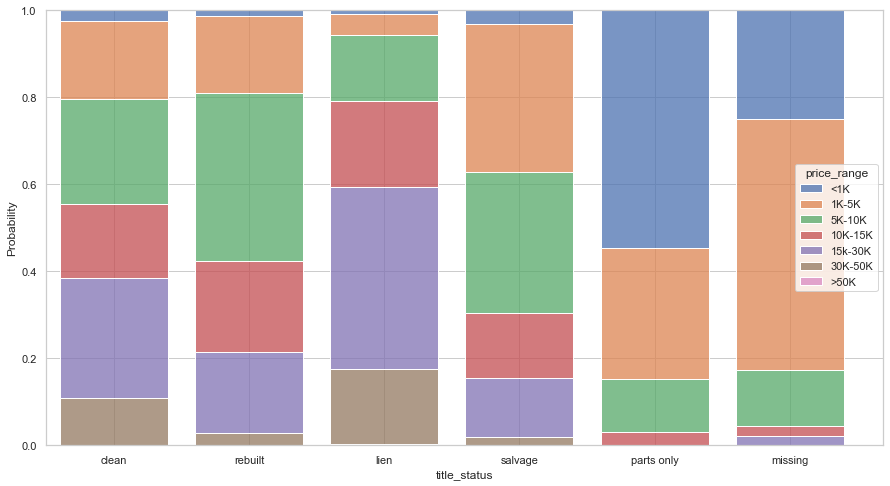

In [350]:
# Draw Seaborn Scatter Plot to find relationship between age and fare
fig, axs = plt.subplots(ncols=1,figsize=(15,8))
sns.histplot(car_df, x="title_status", hue="price_range", stat="probability", multiple="fill", shrink=.8)

# Add description for condition

<AxesSubplot:xlabel='condition_new'>

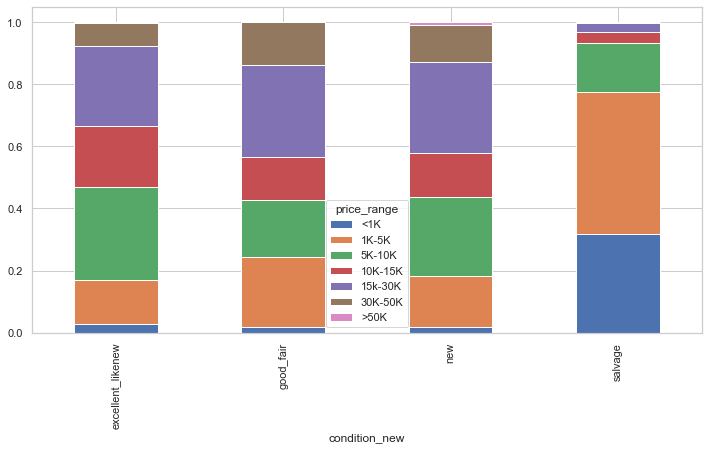

In [356]:
table=pd.crosstab(car_df['condition_new'],car_df['price_range'])
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(12,6),)

<blockquote>When looking at vehicles by the type of fuel they use, at least 50% or more of them are priced in the 10k-50k range.  92% of the vehicles in this dataset use gas for fuel. The high...

<AxesSubplot:xlabel='fuel', ylabel='Probability'>

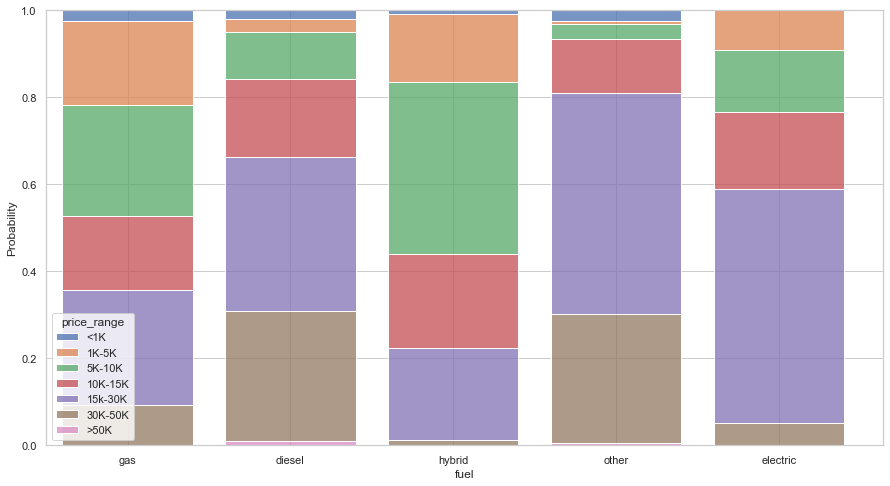

In [358]:
fig, axs = plt.subplots(ncols=1,figsize=(15,8))
sns.histplot(car_df, x="fuel", hue="price_range", stat="probability", multiple="fill", shrink=.8)

<blockquote>
We created new feature column called “ Car Age” which the tell us the age of the car by substracting posting date from the year column. This new column will help us determine whether there is correlation between the car age and the price of the car which seem definitely it has the correlation. <br>
We also do the one hot encoding on the categorical feature variables i.e. manufacturer(41 distinct),condition new(4 distinct), fuel(5 distinct), title status( 6 distinct), transmission(3 distinct transmission), drive(3 distinct), size( 4 distinct), type(10 distinct type), paint color (4 distinct group color) and cylinder.(8 distinct)

### <a id="New-Features">New Features</a>
Are there other features that could be added to the data or created from existing features? Which ones?
* Age in years
* Add details for OHE

In [382]:
car_df_encoded = pd.get_dummies(car_df[[ 'price', 'manufacturer', 'model', 'condition_new',
       'fuel', 'odometer', 'title_status', 'transmission_new', 'drive',
       'type_new', 'paint_color_new', 'cylinders']])

0    1
2    1
4    1
5    1
6    1
Name: fuel_gas, dtype: uint8

<a id='exceptional'></a>

### Exceptional Work

There were columns in the dataset that had missing values. We extracted the information for these columns using the U.S. Department Of Transportation VIN API. (https://vpic.nhtsa.dot.gov/api/). As a valid VIN number is needed to extract information from this API the entire dataset could not be cleanup as many instances were missing VIN number. The following columns were extracted from the VIN API. A scraper was built to call a ReST endpoint and write the details to a file, which was later joined to the original dataset.



| Attribute | Attribute Description | Imputed Column in the Original Dataset |
| --- | --- | --- | 
|VIN | Unique Vehicle Indentifier for a car | Not Mapped. Used for perform join on dataset
| DriveType | Front Wheel Drive, Rear Wheel Drive, All Wheel Drive, etc.| drive
| EngineCylinders | Number of cylinders in the car| cylinders
| EngineManufacturer | Manufacturer Name, for example Ford, GM, etc.| Not Mapped
| EngineModel | The model of the engine | Not Mapped
| Make | Make of the car. For example Toyota, Hyundai, etc. | Not Mapped 
| Manufacturer | Same as engine Manufacturer, but more detailed name | Not Mapped 
| Model | Model of the car. For example Camry, Sonata, etc.| model
| ModelYear | Model when the car was released| year
| PlantCompanyName | Plant where the engine was manufactured| Not Mapped
| TransmissionSpeeds | How many transmissions are present in the car, for Example 4 Speed, 6 Speed etc.|  Not Mapped |
| TransmissionStyle | Kind of transmission. For example, Automatic , Manual, CVT, etc.| transmission |
| FuelTypePrimary | Fuel type used in the car. For example, Gasoline ,Diesel, etc.| fuel |



In [ ]:
def fetch_vin_details(dataset, attribute):
    # List of attributes to filter from the REST response
    vin_attributes = [
        'VIN',
        'DriveType',
        'EngineCylinders',
        'EngineManufacturer',
        'EngineModel',
        'Make',
        'Manufacturer',
        'Model',
        'ModelYear',
        'PlantCompanyName',
        'TransmissionSpeeds',
        'TransmissionStyle',
        'FuelTypePrimary']

    #
    row_list = []
    request_batch_size = 50
    current_fetch_size = 0
    vin_details = ''
    num_requests = 0

    # Create VIN batches so that HTTP requests can be batched to reduce network IO calls for faster processing
    for vin in dataset[attribute]:
        #
        if not pd.isnull(vin):
            #
            vin_details += vin + ';'
            current_fetch_size += 1
            #
            if current_fetch_size == request_batch_size:
                # Introducing a delay to not overload the remote server
                if num_requests == 50:
                    num_requests = 0
                    print(
                        'Going to sleep for sometime to avoid connection refused issue')
                    time.sleep(2)
                # Fetch response from API
                rows = create_http_request(vin_details, vin_attributes)
                vin_details = ''
                current_fetch_size = 0
                num_requests += 1
                row_list.append(rows)

    # Flush out remaining if last fetch size is fewer than the request batch size
    if current_fetch_size < request_batch_size:
        rows = create_http_request(vin_details, vin_attributes)
    row_list.append(rows)

    #
    return row_list


def create_http_request(vin_batch, attributes):
    # construct the batched URL for fetching the VIN information from US DOT
    header = {
        'Accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        'Accept-Encoding': "gzip, deflate, br",
        'Accept-Language': "en-US,en;q=0.5",
        'Connection': "keep-alive",
        'Content-Length': "57",
        'Content-Type': "application/x-www-form-urlencoded",
        'Host': "vpic.nhtsa.dot.gov",
        'Origin': "https://vpic.nhtsa.dot.gov",
        'Referer': "https://vpic.nhtsa.dot.gov/api/",
        'Upgrade-Insecure-Requests': "1",
        'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:84.0) Gecko/20100101 Firefox/84.0"
    }

    url = 'https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVINValuesBatch/'

    data_dict = {'DATA': vin_batch, 'format': 'JSON'}

    # Parse the raw response in JSON format
    response_raw = requests.post(
        url, headers=header, data=data_dict)

    # Parse if we get a sucessfull response, else return a null list
    if not response_raw.status_code == requests.codes.ok:
        print("Unable to get a reponse at {} for url , {} , {} ".format(
            datetime.now(), url, response_raw.text))
        return []

    #
    # print(response_raw.text)
    response_json = json.loads(response_raw.text)

    with open('vin_data.csv', 'a') as file:
        # Create a dataframe from the JSON response
        rows = []
        for elements in range(0, response_json['Count']):
            values = []
            for key in attributes:
                values.append(response_json['Results'][elements][key])
            rows.append(values)
            file.write("|".join([str(element) for element in values])+"\n")
            file.flush()
    #
    print("Fetched {} records from API at {}".format(len(rows), datetime.now()))
    file.close()
    #
    return rows


def unpack_list_to_df(row_list):
    #
    df_list = []

    for indx in range(0, len(row_list)):
        for iter in range(0, len(row_list[indx])):
            df_list.append(row_list[indx][iter])

    #
    return pd.DataFrame(df_list, columns=[
        'VIN',
        'DriveType',
        'EngineCylinders',
        'EngineManufacturer',
        'EngineModel',
        'Make',
        'Manufacturer',
        'Model',
        'ModelYear',
        'PlantCompanyName',
        'TransmissionSpeeds',
        'TransmissionStyle',
        'FuelTypePrimary'])

<hr>

Extra Plots (to be moved or deleted)

In [ ]:
#histograms
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=False)
sns.distplot(car_df['price'] , color="skyblue", ax=axes[0])
sns.distplot(car_df['year'] , color="skyblue", ax=axes[1])
sns.distplot(car_df['odometer'] , color="skyblue", ax=axes[2])


In [190]:
#breakdown of car condition
car_df.groupby('condition_new')['id'].nunique()

condition
excellent    115201
fair         7740  
good         115681
like new     24551 
new          1428  
salvage      661   
Name: id, dtype: int64

Text(0, 0.5, 'Frequency')

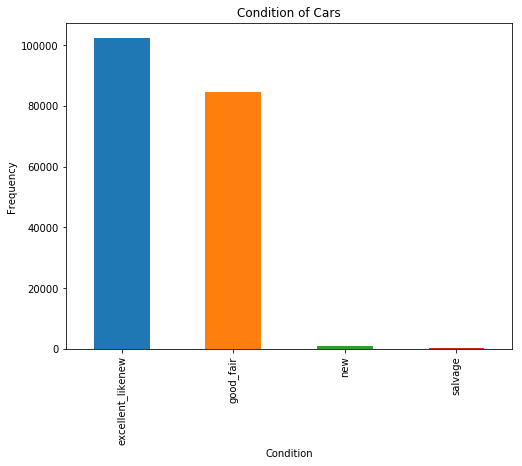

In [36]:
#plot the conditions
ax = car_df['condition_new'].value_counts().plot(kind='bar',
                                    figsize=(8,6),
                                    title="Condition of Cars")
ax.set_xlabel("Condition")
ax.set_ylabel("Frequency")

In [194]:
#odometer
car_df['odometer'].describe()

count    4.029010e+05
mean     1.016679e+05
std      3.228658e+06
min      0.000000e+00
25%      4.087700e+04
50%      8.764100e+04
75%      1.340000e+05
max      2.043756e+09
Name: odometer, dtype: float64

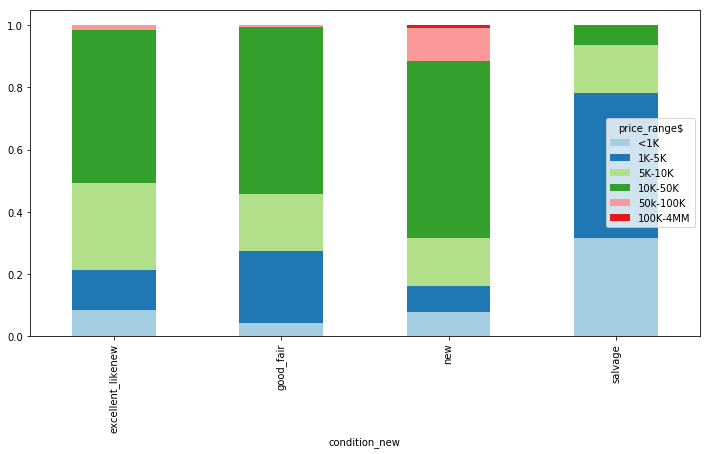

In [ ]:
#view condition by
car_df2.groupby(by=['condition_new']).info()